# Predicting University Graduation Rates
**Objective**   
Build a regression model to predict 4-year university graduation rates in schools in the US

**Data**   
Data from more than 1,600 4-year public and private universities in the United States was scraped from [College Results Online.](collegeresults.org)

In [41]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

**Scrape and clean the data**

In [7]:
def str_to_int(string):
    '''
    A helper function to turn a string to an integer

    Parameters
    ----------
    string : A string of text.

    Returns
    -------
    A floating point number if the text is a number and None otherwise.
    '''
    try:
        return float(string)
    except (IndexError, ValueError):
        return None

In [8]:
def get_school_id_links():
    '''
    A helper function that loads in a csv file with universities and their unique
    links in order to webscrape data about them.

    Returns
    -------
    A list of links to use and a college_df with the name of the university.
    '''
    # Load in csv with unviersities and IPEDS ID
    college_df = pd.read_csv("../Data/4-Year-Public-and-Private-Universities-and-IPEDS-IDs.csv")

    # Convert ipeds_id column to string
    college_df.ipeds_id = college_df.ipeds_id.apply(str)

    # Saves the ID links
    links_to_follow = college_df.ipeds_id

    return links_to_follow, college_df

In [9]:
def get_college_dict(link):
    '''
    Creates a dictionary of the categories of scraped data for each university

    Parameters
    ----------
    id_link : The unique part of the link for one university.

    Returns
    -------
    A dictionary of scraped data for each of the univerisities.
    '''
    #Develop base URL
    base_url = "http://www.collegeresults.org/collegeprofile.aspx?institutionid="

    #Create full URL to scrape
    url = base_url + link

    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")

    headers = ["ipeds_id", "college_name", "state", "size_undergrads", "percent_admitted",
               "in_state_tuition", "out_state_tuition", "sector", "average_gpa",
               "percent_part_time", "admission_test", "median_sat_verbal", "median_sat_math",
               "median_act_composite", "percent_underrep_minority", "pell_percent",
               "retention_rate", "four_year_grad_rate", "five_year_grad_rate", "six_year_grad_rate"]

    #ipeds_id
    ipeds_id = link

    # Name of college
    college_name = soup.find('h2').text

    # State
    state = soup.find_all(class_='data')[3].text

    # Size of undergrads
    raw_size_undergrads = soup.find_all(class_='data')[13].text.replace(",", "")
    size_undergrads = str_to_int(raw_size_undergrads)

    # Percent Admitted
    raw_percent_admitted = soup.find_all(class_='data')[26].text[:-1]
    percent_admitted = str_to_int(raw_percent_admitted)

    # In-State Tuition and Fees
    raw_in_state_tuition = soup.find_all(class_='data')[27].text[1:].replace(",", "")
    in_state_tuition = str_to_int(raw_in_state_tuition)

    # Out-of-State Tuition and Fees
    raw_out_state_tuition = soup.find_all(class_='data')[28].text[1:].replace(",", "")
    out_state_tuition = str_to_int(raw_out_state_tuition)

    # Sector (public or private)
    sector = soup.find_all(class_='data')[11].text

    # Average High School GPA Among College Freshmen
    raw_average_gpa = soup.find_all(class_='data')[19].text
    average_gpa = str_to_int(raw_average_gpa)

    # % Part time
    raw_percent_part_time = soup.find_all(class_='data')[49].text[:-1]
    percent_part_time = str_to_int(raw_percent_part_time)

    # Admission Test Scores Policy
    admission_test = soup.find_all(class_='data')[20].text

    # Median SAT Verbal
    raw_median_sat_verbal = soup.find_all(class_='data')[21].text[:3]
    median_sat_verbal = str_to_int(raw_median_sat_verbal)

    # Median SAT Math
    raw_median_sat_math = soup.find_all(class_='data')[22].text[:3]
    median_sat_math = str_to_int(raw_median_sat_math)

    # Median ACT Composite
    raw_median_act_composite = soup.find_all(class_='data')[24].text[:4]
    median_act_composite = str_to_int(raw_median_act_composite)

    # % Underrepresented minority
    raw_percent_underrep_minority = soup.find_all(class_='data')[36].text[:-1]
    percent_underrep_minority = str_to_int(raw_percent_underrep_minority)

    # Percent Pell grants
    raw_pell_percent = soup.find_all(class_='data')[35].text[:-1]
    pell_percent = str_to_int(raw_pell_percent)

    #First-year retention rate
    raw_retention_rate = soup.find_all(class_='data')[6].text[:-1]
    retention_rate = str_to_int(raw_retention_rate)

    # Four-year graduation rate
    raw_four_year_grad_rate = soup.find_all(class_='data')[7].text[:-1]
    four_year_grad_rate = str_to_int(raw_four_year_grad_rate)

    # Five-year graduation rate
    raw_five_year_grad_rate = soup.find_all(class_='data')[8].text[:-1]
    five_year_grad_rate = str_to_int(raw_five_year_grad_rate)

    # Six-year graduation rate
    raw_six_year_grad_rate = soup.find_all(class_='data')[9].text[:-1]
    six_year_grad_rate = str_to_int(raw_six_year_grad_rate)

    college_dict = dict(zip(headers, [ipeds_id, college_name, state, size_undergrads,
                                      percent_admitted, in_state_tuition, out_state_tuition,
                                      sector, average_gpa, percent_part_time, admission_test,
                                      median_sat_verbal, median_sat_math, median_act_composite,
                                      percent_underrep_minority, pell_percent, retention_rate,
                                      four_year_grad_rate, five_year_grad_rate,
                                      six_year_grad_rate]))

    return college_dict

In [10]:
def scrape_college_results_online(links_to_follow, college_df):
    '''
    Returns a dataframe with information scraped from College Results Online.

    Parameters
    ----------
    links_to_follow : The list of unique parts of the links for the univerisities.
    college_df : A dataframe with the names of univerisities and their id_links

    Returns
    -------
    A dataframe containing the information for univerisities.
    '''
    college_id_list = []

    for link in links_to_follow:
        try:
            college_id_list.append(get_college_dict(link))
        except NameError:
            continue

    college_page_info = pd.DataFrame(college_id_list)
    college_page_info.set_index('ipeds_id', inplace=True)

    # Reset the index for the college-df
    college_df.set_index('ipeds_id', inplace=True)

    # Merge the 2 dataframes
    college_df = college_df.merge(college_page_info, left_index=True, right_index=True)

    # Reset the index of the dataframe
    college_df = college_df.reset_index()

    return college_df

In [11]:
def clean_college_dataframe(college_df):
    '''
    This function cleans the college_df dataframe by removing duplicate columns, duplicate
    rows, and dropping rows with NaN values in certain columns.

    Parameters
    ----------
    college_df : The college dataframe.

    Returns
    -------
    college_df : A cleaner version of college_df.
    '''
    # Convert ipeds_id column to float
    college_df.ipeds_id = college_df.ipeds_id.apply(float)

    # Drop college name column (duplicate column)
    college_df = college_df.drop(columns=["college_name"])

    # Drop sector = for-profit (don't want these included)
    college_df.drop(college_df[college_df['sector'] == "Private for-profit"].index, inplace=True)

    # Drop sector = - (found these all to be for-profit)
    college_df.drop(college_df[college_df['sector'] == "-"].index, inplace=True)

    # Drop specific columns with missing values
    college_df = college_df.dropna(subset=['in_state_tuition', 'out_state_tuition', 'pell_percent',
                                           'percent_admitted', 'retention_rate', 'admission_test',
                                           'four_year_grad_rate', 'five_year_grad_rate',
                                           'six_year_grad_rate'])
    return college_df

In [12]:
def clean_missing_gpa(college_df):
    '''
    This function cleans the college_df dataframe by filling in missing values of the GPA
    column with averages based on the number of applicants the university admits.

    Parameters
    ----------
    college_df : The college dataframe.

    Returns
    -------
    college_df : A cleaner version of college_df.
    '''
    # Percent admitted at 20% or below
    select20 = college_df["percent_admitted"] <= 20
    college_df[select20] = college_df[select20].fillna(college_df.average_gpa.mean())

    # Percent admitted at between 21-40%
    select21_40 = ((college_df["percent_admitted"] > 20) & (college_df.percent_admitted <= 40))
    college_df[select21_40] = college_df[select21_40].fillna(college_df.average_gpa.mean())

    # Percent admitted at between 41-60%
    select41_60 = ((college_df["percent_admitted"] > 40) & (college_df.percent_admitted <= 60))
    college_df[select41_60] = college_df[select41_60].fillna(college_df.average_gpa.mean())

    select61_80 = ((college_df["percent_admitted"] > 60) & (college_df.percent_admitted <= 80))
    college_df[select61_80] = college_df[select61_80].fillna(college_df.average_gpa.mean())

    # Percent admitted at between 81-99%
    select81_99 = ((college_df["percent_admitted"] > 80) & (college_df.percent_admitted < 100))
    college_df[select81_99] = college_df[select81_99].fillna(college_df.average_gpa.mean())

    # Percent admitted = 100%
    select100 = college_df["percent_admitted"] == 100
    college_df[select100] = college_df[select100].fillna(college_df.average_gpa.mean())

    return college_df

In [13]:
def clean_missing_sat_reading(college_df):
    '''
    This function cleans the college_df dataframe by filling in missing values of the SAT
    Reading column with averages based on the number of applicants the university admits.

    Parameters
    ----------
    college_df : The college dataframe.

    Returns
    -------
    college_df : A cleaner version of college_df.
    '''
    # Percent admitted at 20% or below
    sat_verbal_select20 = college_df["percent_admitted"] <= 20
    college_df[sat_verbal_select20] = college_df[sat_verbal_select20].fillna(
        college_df.median_sat_verbal.mean())

    # Percent admitted at between 21-40%
    sat_verbal_select21_40 = ((college_df["percent_admitted"] > 20) &
                              (college_df.percent_admitted <= 40))
    college_df[sat_verbal_select21_40] = college_df[sat_verbal_select21_40].fillna(
        college_df.median_sat_verbal.mean())

    # Percent admitted at between 41-60%
    sat_verbal_select41_60 = ((college_df["percent_admitted"] > 40) &
                              (college_df.percent_admitted <= 60))
    college_df[sat_verbal_select41_60] = college_df[sat_verbal_select41_60].fillna(
        college_df.median_sat_verbal.mean())

    # Percent admitted at between 61-80%
    sat_verbal_select61_80 = ((college_df["percent_admitted"] > 60) &
                              (college_df.percent_admitted <= 80))
    college_df[sat_verbal_select61_80] = college_df[sat_verbal_select61_80].fillna(
        college_df.median_sat_verbal.mean())

    # Percent admitted at between 81-99%
    sat_verbal_select81_99 = ((college_df["percent_admitted"] > 80) &
                              (college_df.percent_admitted < 100))
    college_df[sat_verbal_select81_99] = college_df[sat_verbal_select81_99].fillna(
        college_df.median_sat_verbal.mean())

    # Percent admitted = 100%
    sat_verbal_select100 = college_df["percent_admitted"] == 100
    college_df[sat_verbal_select100] = college_df[sat_verbal_select100].fillna(
        college_df.median_sat_verbal.mean())

    return college_df

In [14]:
def clean_missing_sat_math(college_df):
    '''
    This function cleans the college_df dataframe by filling in missing values of the SAT
    Math column with averages based on the number of applicants the university admits.

    Parameters
    ----------
    college_df : The college dataframe.

    Returns
    -------
    college_df : A cleaner version of college_df.
    '''
    # Percent admitted at 20% or below
    sat_math_select20 = college_df["percent_admitted"] <= 20
    college_df[sat_math_select20] = college_df[sat_math_select20].fillna(
        college_df.median_sat_math.mean())

    # Percent admitted at between 21-40%
    sat_math_select21_40 = ((college_df["percent_admitted"] > 20) &
                            (college_df.percent_admitted <= 40))
    college_df[sat_math_select21_40] = college_df[sat_math_select21_40].fillna(
        college_df.median_sat_math.mean())

    # Percent admitted at between 41-60%
    sat_math_select41_60 = ((college_df["percent_admitted"] > 40) &
                            (college_df.percent_admitted <= 60))
    college_df[sat_math_select41_60] = college_df[sat_math_select41_60].fillna(
        college_df.median_sat_math.mean())

    # Percent admitted at between 61-80%
    sat_math_select61_80 = ((college_df["percent_admitted"] > 60) &
                            (college_df.percent_admitted <= 80))
    college_df[sat_math_select61_80] = college_df[sat_math_select61_80].fillna(
        college_df.median_sat_math.mean())

    # Percent admitted at between 81-99%
    sat_math_select81_99 = ((college_df["percent_admitted"] > 80) &
                            (college_df.percent_admitted < 100))
    college_df[sat_math_select81_99] = college_df[sat_math_select81_99].fillna(
        college_df.median_sat_math.mean())

    # Percent admitted = 100%
    sat_math_select100 = college_df["percent_admitted"] == 100
    college_df[sat_math_select100] = college_df[sat_math_select100].fillna(
        college_df.median_sat_math.mean())

    return college_df

In [15]:
def clean_missing_act(college_df):
    '''
    This function cleans the college_df dataframe by filling in missing values of the ACT
    column with averages based on the number of applicants the university admits.

    Parameters
    ----------
    college_df : The college dataframe.

    Returns
    -------
    college_df : A cleaner version of college_df.
    '''
    # Percent admitted at 20% or below
    act_select20 = college_df["percent_admitted"] <= 20
    college_df[act_select20] = college_df[act_select20].fillna(
        college_df.median_act_composite.mean())

    # Percent admitted at between 21-40%
    act_select21_40 = ((college_df["percent_admitted"] > 20) &
                       (college_df.percent_admitted <= 40))
    college_df[act_select21_40] = college_df[act_select21_40].fillna(
        college_df.median_act_composite.mean())

    # Percent admitted at between 41-60%
    act_select41_60 = ((college_df["percent_admitted"] > 40) &
                       (college_df.percent_admitted <= 60))
    college_df[act_select41_60] = college_df[act_select41_60].fillna(
        college_df.median_act_composite.mean())

    # Percent admitted at between 61-80%
    act_select61_80 = ((college_df["percent_admitted"] > 60) &
                       (college_df.percent_admitted <= 80))
    college_df[act_select61_80] = college_df[act_select61_80].fillna(
        college_df.median_act_composite.mean())

    # Percent admitted at between 81-99%
    act_select81_99 = ((college_df["percent_admitted"] > 80) &
                       (college_df.percent_admitted < 100))
    college_df[act_select81_99] = college_df[act_select81_99].fillna(
        college_df.median_act_composite.mean())

    # Percent admitted = 100%
    act_select100 = college_df["percent_admitted"] == 100
    college_df[act_select100] = college_df[act_select100].fillna(
        college_df.median_act_composite.mean())

    return college_df

In [16]:
def final_data_cleaning(college_df):
    '''
    This function cleans the college_df dataframe by adding dummy variables and then drops
    four- and six-year graduation rates. The final dataframe is saved as a csv file.

    Parameters
    ----------
    college_df : The college dataframe.

    Returns
    -------
    five_college_df : A final cleaned version of the college dataframe with only five-year
    graduation rates that has been saved to a csv file.
    '''
    # Create dummy variables
    college_df = pd.get_dummies(college_df, prefix=['sector', 'admission_test'],
                                columns=['sector', 'admission_test'], drop_first=True)

    # Convert dummy variable types to int
    college_df.sector_Public = college_df.sector_Public.apply(int)
    college_df["admission_test_Considered but not required"] = college_df[
                "admission_test_Considered but not required"].apply(int)
    college_df["admission_test_Neither required nor recommended"] = college_df[
                "admission_test_Neither required nor recommended"].apply(int)
    college_df["admission_test_Recommended"] = college_df["admission_test_Recommended"].apply(int)
    college_df["admission_test_Required"] = college_df["admission_test_Required"].apply(int)

    # Create a data frame with just 5 year graduation rate as predictor
    five_college_df = college_df.drop(['four_year_grad_rate', 'six_year_grad_rate'], axis=1)

    # Save dataframe to csv files
    five_college_df.to_csv(r'five_college_df.csv', index=False)

**EDA**

In [89]:
# Load in cleaned dataframes (above scripts were ran at an earlier time)
five_college_df = pickle.load(open("five_cleaned_college_df.pkl","rb"))

In [32]:
five_college_df.head()

IPEDS_ID                     Institution_name state  size_undergrads  \
0  100654.0             Alabama A & M University    AL           5038.0   
1  100663.0  University of Alabama at Birmingham    AL          13134.0   
2  100706.0  University of Alabama in Huntsville    AL           7090.0   
3  100724.0             Alabama State University    AL           4208.0   
4  100751.0            The University of Alabama    AL          33305.0   

   percent_admitted  in_state_tuition  out_state_tuition  average_gpa  \
0              87.4            9366.0            17496.0        3.302   
1              58.1            8040.0            18368.0        3.650   
2              76.3            9842.0            20612.0        3.790   
3              45.9            9220.0            16156.0        2.800   
4              52.6           10470.0            26950.0        3.690   

   percent_part_time  median_sat_verbal  ...  retention_rate  \
0                8.6              425.0  ...            58.0   
1               27.5              560.0  ...            82.0   
2               19.2              590.0  ...            83.0   
3                7.6              415.0  ...            63.0   
4               10.3              550.0  ...            86.0   

   five_year_grad_rate  sector_Public  \
0                 16.7              1   
1                 47.8              1   
2                 45.4              1   
3                 23.1              1   
4                 63.6              1   

   admission_test_Considered but not required  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   admission_test_Neither required nor recommended  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   admission_test_Recommended  admission_test_Required  act_and_test_required  \
0                           0                        1                   17.5   
1                           0                        1                   24.5   
2                           0                        1                   28.0   
3                           0                        1                   17.0   
4                           0                        1                   27.0   

   math_sat_and_test_required  verbal_sat_and_test_required  
0                       420.0                         425.0  
1                       575.0                         560.0  
2                       610.0                         590.0  
3                       410.0                         415.0  
4                       555.0                         550.0  

[5 rows x 24 columns]

In [21]:
five_college_df.isnull().sum()

IPEDS_ID                                           0
Institution_name                                   0
state                                              0
size_undergrads                                    0
percent_admitted                                   0
in_state_tuition                                   0
out_state_tuition                                  0
average_gpa                                        0
percent_part_time                                  0
median_sat_verbal                                  0
median_sat_math                                    0
median_act_composite                               0
percent_underrep_minority                          0
pell_percent                                       0
retention_rate                                     0
five_year_grad_rate                                0
sector_Public                                      0
admission_test_Considered but not required         0
admission_test_Neither required nor recommende

In [22]:
five_college_df.describe()

IPEDS_ID  size_undergrads  percent_admitted  in_state_tuition  \
count    1644.000000      1644.000000       1644.000000       1644.000000   
mean   192506.262774      5322.349757         68.564903      22424.870438   
std     65844.210768      7749.864040         21.269497      13932.393766   
min    100654.000000        24.000000          4.800000          0.000000   
25%    153968.250000      1074.750000         55.675000       9457.500000   
50%    188384.500000      2177.500000         70.000000      20400.000000   
75%    214991.500000      5973.500000         84.025000      32945.000000   
max    489937.000000     70661.000000        100.000000      55056.000000   

       out_state_tuition  average_gpa  percent_part_time  median_sat_verbal  \
count        1644.000000  1644.000000        1644.000000        1644.000000   
mean        26354.232968     3.353785          15.899088         518.589538   
std         11455.777663     0.285322          15.287758          61.758244   
min             0.000000     2.150000           0.000000         315.000000   
25%         17542.000000     3.197500           4.200000         475.000000   
50%         25170.500000     3.374000          11.650000         515.000000   
75%         33738.500000     3.510000          22.900000         541.250000   
max         55056.000000     4.660000          88.600000         770.000000   

       median_sat_math  median_act_composite  ...  retention_rate  \
count      1644.000000           1644.000000  ...     1644.000000   
mean        524.905779             22.697987  ...       75.228710   
std          66.185372              3.519930  ...       13.002739   
min         355.000000              5.500000  ...        9.000000   
25%         480.000000             20.500000  ...       68.000000   
50%         515.000000             22.500000  ...       77.000000   
75%         545.000000             24.000000  ...       84.000000   
max         785.000000             35.000000  ...      100.000000   

       five_year_grad_rate  sector_Public  \
count          1644.000000    1644.000000   
mean             50.577196       0.353406   
std              20.635232       0.478173   
min               0.900000       0.000000   
25%              36.600000       0.000000   
50%              50.250000       0.000000   
75%              65.000000       1.000000   
max              96.400000       1.000000   

       admission_test_Considered but not required  \
count                                 1644.000000   
mean                                     0.041971   
std                                      0.200583   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                      0.000000   
max                                      1.000000   

       admission_test_Neither required nor recommended  \
count                                      1644.000000   
mean                                          0.065085   
std                                           0.246751   
min                                           0.000000   
25%                                           0.000000   
50%                                           0.000000   
75%                                           0.000000   
max                                           1.000000   

       admission_test_Recommended  admission_test_Required  \
count                 1644.000000              1644.000000   
mean                     0.094282                 0.711071   
std                      0.292310                 0.453403   
min                      0.000000                 0.000000   
25%                      0.000000                 0.000000   
50%                      0.000000                 1.000000   
75%                      0.000000                 1.000000   
max                      1.000000                 1.000000   

       act_and_tes

In [23]:
five_college_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1644 entries, 0 to 1672
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   IPEDS_ID                                         1644 non-null   float64
 1   Institution_name                                 1644 non-null   object 
 2   state                                            1644 non-null   object 
 3   size_undergrads                                  1644 non-null   float64
 4   percent_admitted                                 1644 non-null   float64
 5   in_state_tuition                                 1644 non-null   float64
 6   out_state_tuition                                1644 non-null   float64
 7   average_gpa                                      1644 non-null   float64
 8   percent_part_time                                1644 non-null   float64
 9   median_sat_verbal             

In [24]:
# Examine multicollinearity
five_college_df.corr()

IPEDS_ID  size_undergrads  \
IPEDS_ID                                         1.000000        -0.090369   
size_undergrads                                 -0.090369         1.000000   
percent_admitted                                 0.131348        -0.076669   
in_state_tuition                                -0.113200        -0.300618   
out_state_tuition                               -0.134953        -0.029282   
average_gpa                                     -0.063228         0.233665   
percent_part_time                               -0.063734         0.110903   
median_sat_verbal                               -0.064970         0.201861   
median_sat_math                                 -0.069565         0.257032   
median_act_composite                            -0.096761         0.233841   
percent_underrep_minority                       -0.045657         0.016880   
pell_percent                                     0.117109        -0.188016   
retention_rate                                  -0.053137         0.248420   
five_year_grad_rate                             -0.104966         0.133656   
sector_Public                                   -0.007878         0.513987   
admission_test_Considered but not required      -0.022080        -0.058682   
admission_test_Neither required nor recommended  0.099238        -0.101648   
admission_test_Recommended                       0.006274        -0.078513   
admission_test_Required                         -0.128485         0.190506   
act_and_test_required                           -0.133572         0.244150   
math_sat_and_test_required                      -0.131370         0.245962   
verbal_sat_and_test_required                    -0.130371         0.229780   

                                                 percent_admitted  \
IPEDS_ID                                                 0.131348   
size_undergrads                                         -0.076669   
percent_admitted                                         1.000000   
in_state_tuition                                        -0.346004   
out_state_tuition                                       -0.391989   
average_gpa                                             -0.379264   
percent_part_time                                        0.235219   
median_sat_verbal                                       -0.527734   
median_sat_math                                         -0.534565   
median_act_composite                                    -0.556790   
percent_underrep_minority                               -0.023651   
pell_percent                                             0.269967   
retention_rate                                          -0.315014   
five_year_grad_rate                                     -0.425061   
sector_Public                                            0.121363   
admission_test_Considered but not required              -0.025120   
admission_test_Neither required nor recommended          0.003636   
admission_test_Recommended                              -0.027612   
admission_test_Required                                 -0.258756   
act_and_test_required                                   -0.342080   
math_sat_and_test_required                              -0.341969   
verbal_sat_and_test_required                            -0.336924   

                                                 in_state_tuition  \
IPEDS_ID                                                -0.113200   
size_undergrads                                         -0.300618   
percent_admitted                                        -0.346004   
in_state_tuition                                         1.000000   
out_state_tuition                                        0.897687   
average_gpa                                              0.342245   
percent_part_time                                       -0.390669   
median_sat_verbal                                        0.457796   
median_sat_math                              

limit_output extension: Maximum message size of 10000 exceeded with 32793 characters

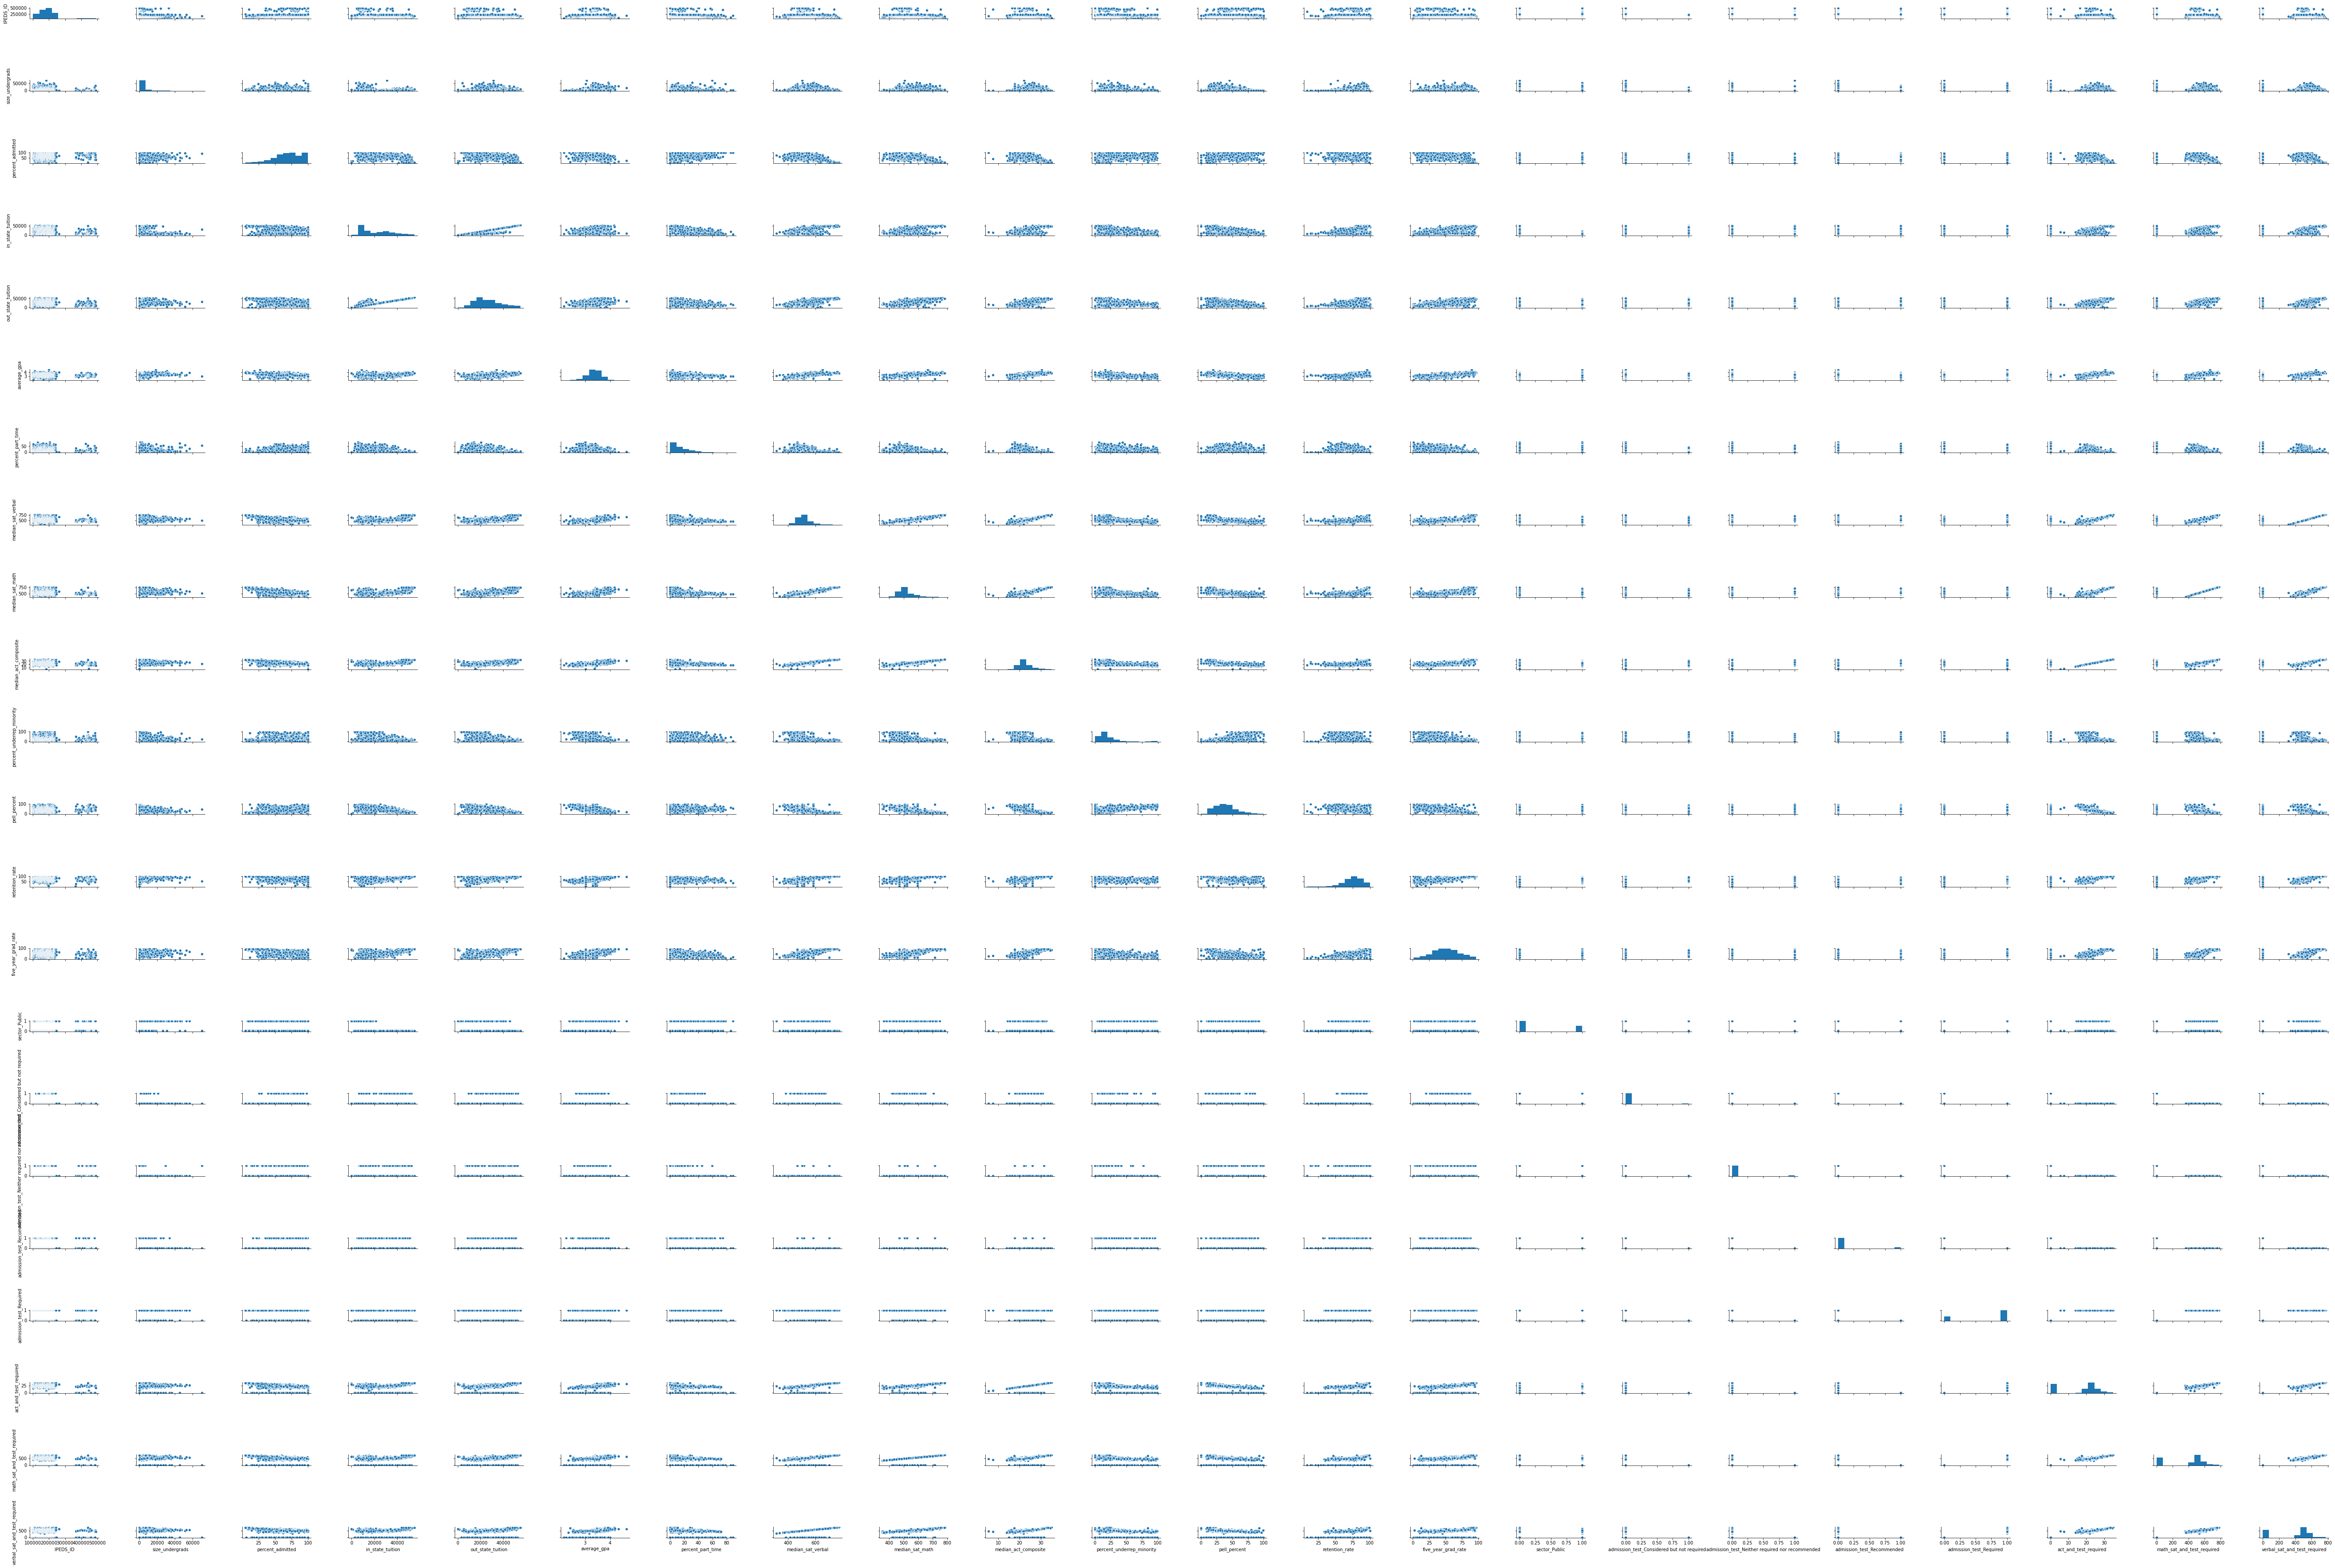

In [25]:
# Examine pairplot
sns.pairplot(five_college_df, height=2.2, aspect=1.5)

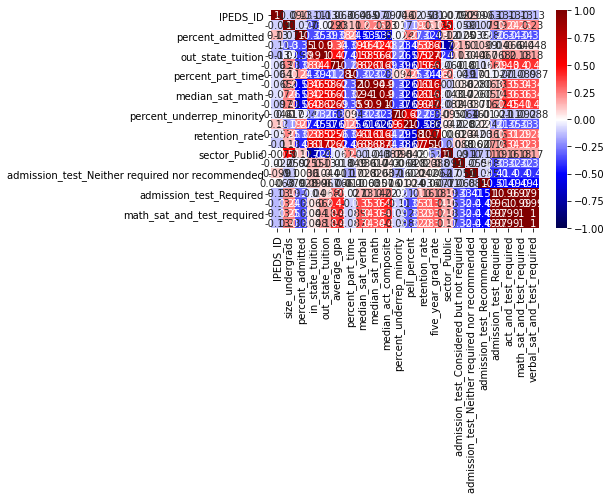

In [26]:
# Heatmap of correlations
sns.heatmap(five_college_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

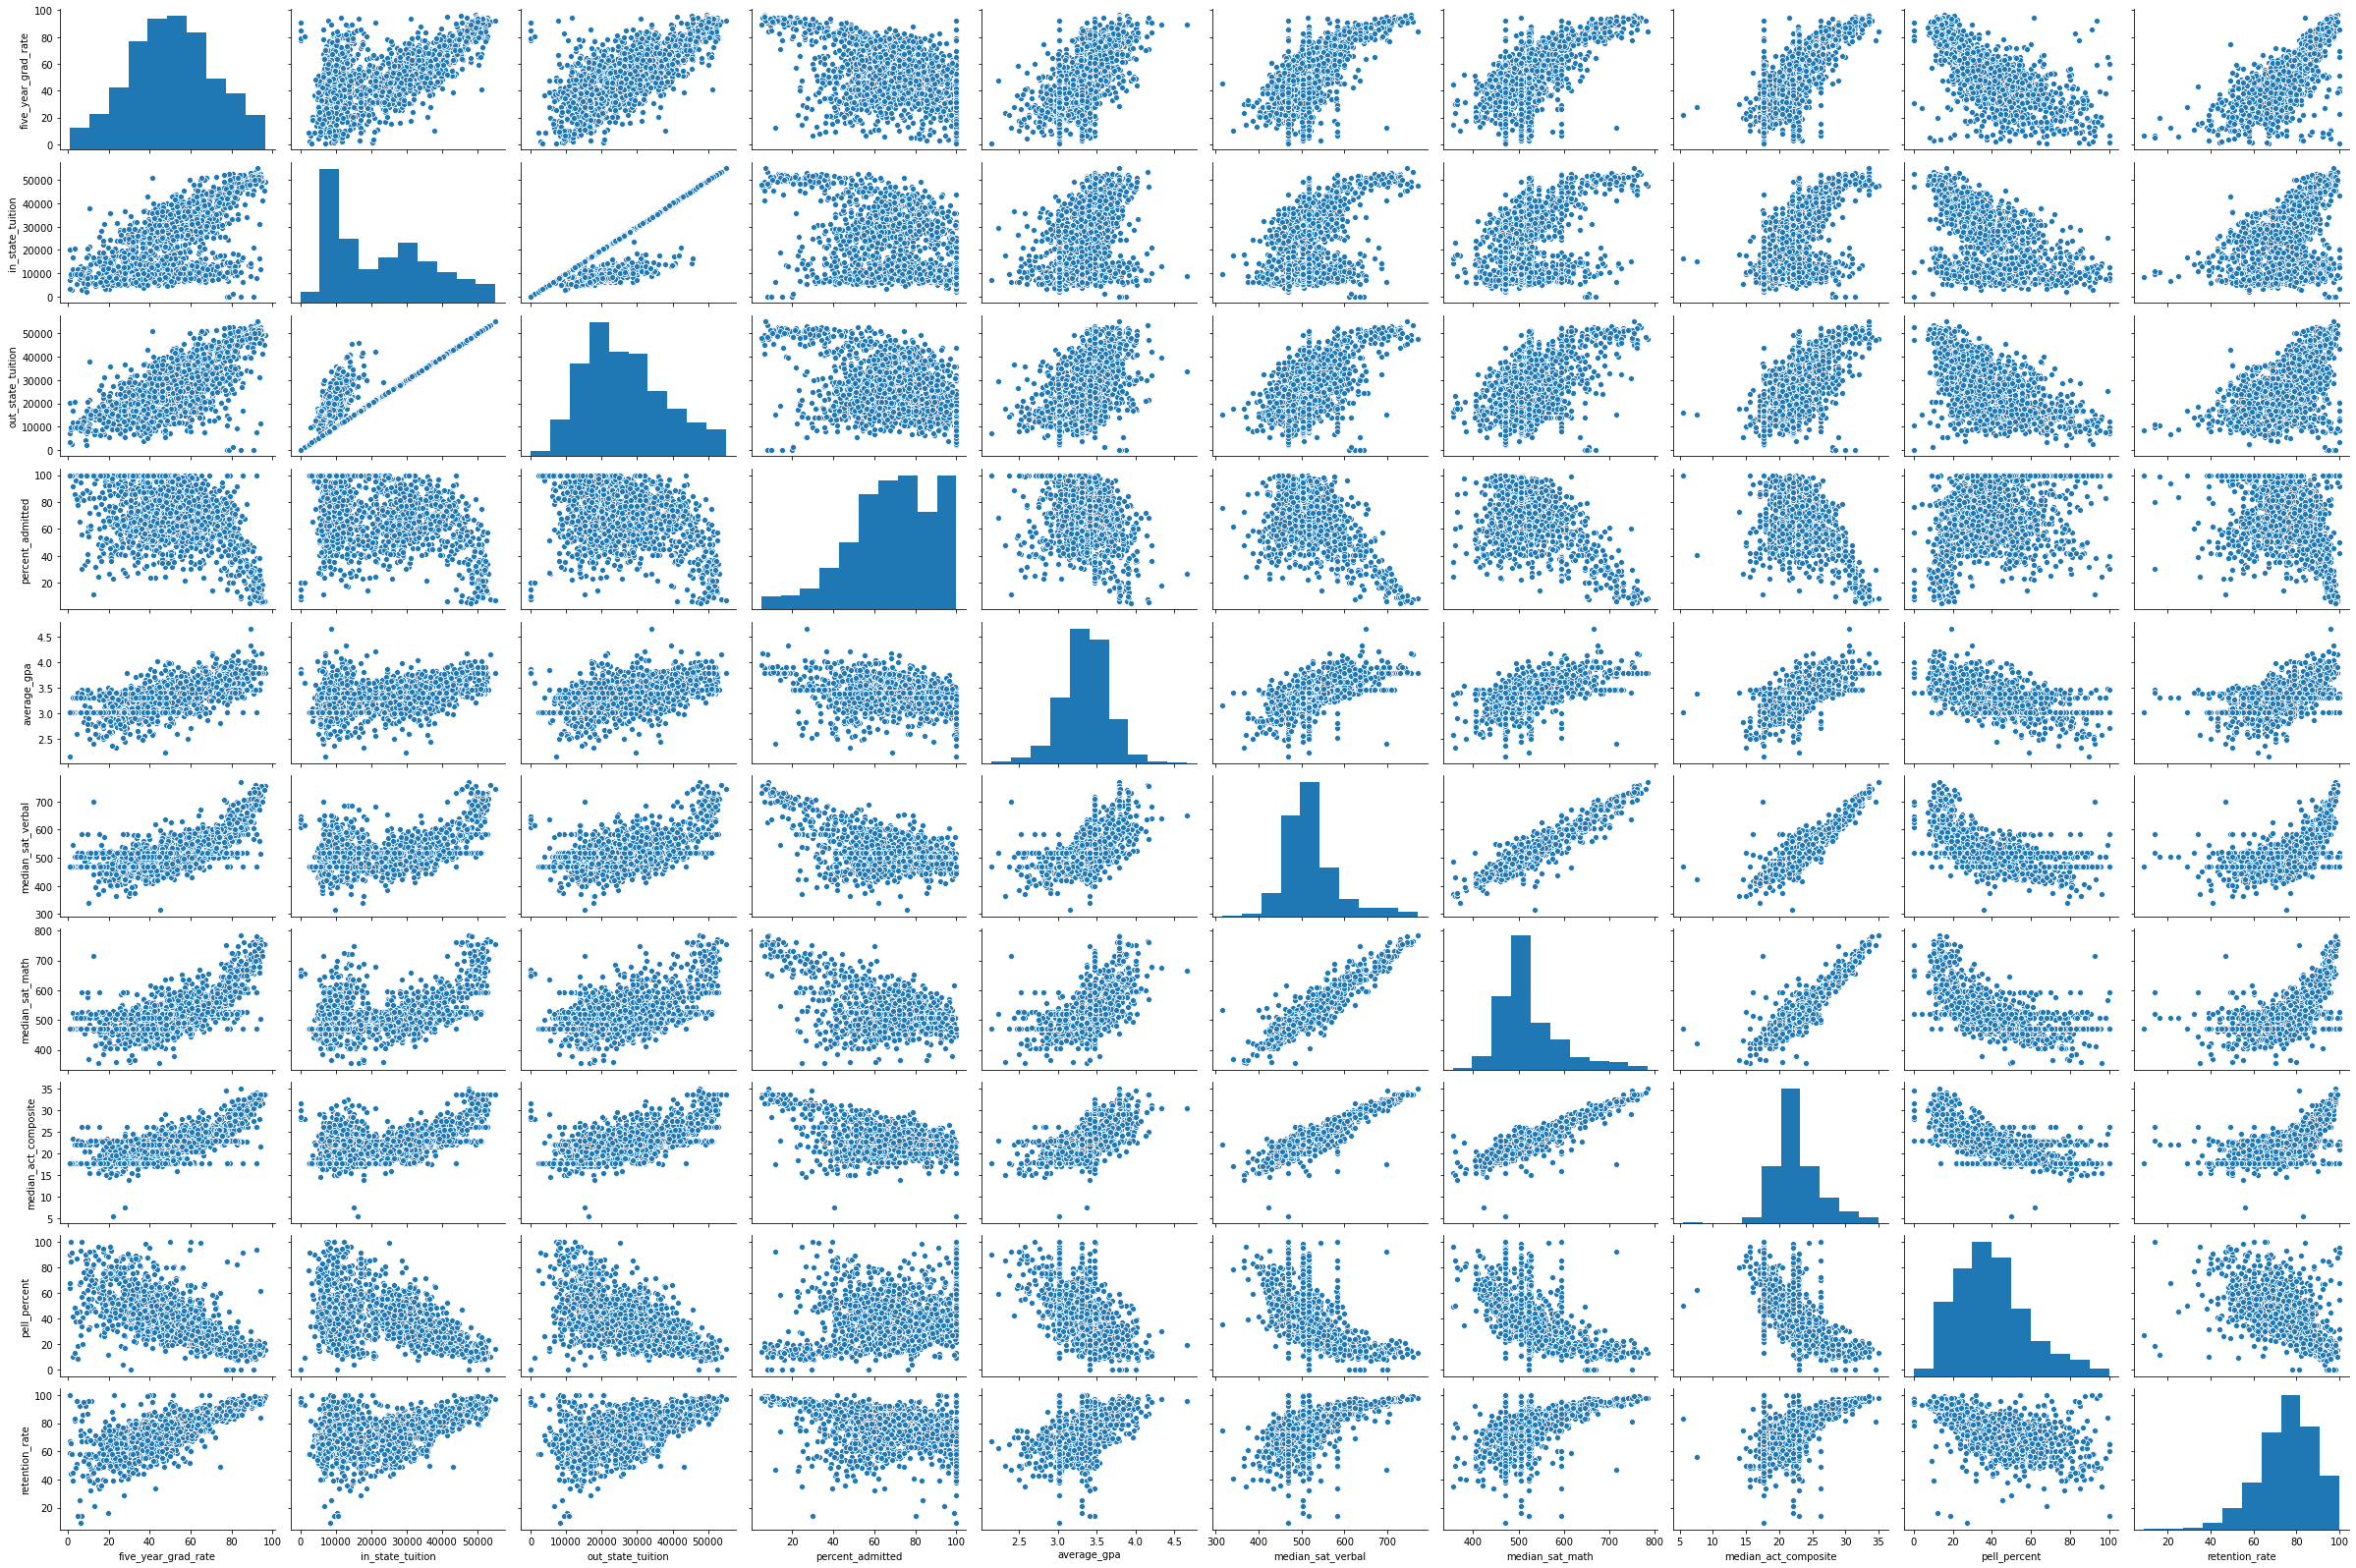

In [27]:
# Pairplot (non-dummy)
non_dummy = five_college_df.loc[:,["five_year_grad_rate", 'in_state_tuition', 'out_state_tuition',
       'percent_admitted', 'average_gpa', 'median_sat_verbal', 'median_sat_math', 
        'median_act_composite','pell_percent', "retention_rate"]]

sns.pairplot(non_dummy, height=2.2, aspect=1.5)

**Modeling**

In [33]:
# Prepare the data
def separate_features_and_target(dataframe):
    '''
    Returns 2 dataframes where features contains only the features for the
    model and target contains the targets.
    '''

    features_grad_rate, target_grad_rate = dataframe.drop('five_year_grad_rate', axis=1), dataframe['five_year_grad_rate']

    return features_grad_rate, target_grad_rate

def train_test_split_data(five_college_df):
    '''
    Return train and test dataframes.
    '''

    feature_grad_rate, target_grad_rate = separate_features_and_target(five_college_df)

    x_train, x_test, y_train, y_test = train_test_split(feature_grad_rate, target_grad_rate, test_size=.2)

    return x_train, x_test, y_train, y_test

In [100]:
# Define models to test with cross validation on training data 

def linear_regression_model_testing(x_data, y_data):
    '''
    A function that models data with a linear regression model using cross-validation
    without scaling.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.

    Returns
    -------
    Prints the R^2 average of the k-folds for the train and test data, and the
    Mean Square Error of the model.
    '''
    k_folds = KFold(n_splits=5, shuffle=True)

    r2_train, r2_val, mse = [], [], []

    for train_ind, val_ind in k_folds.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        linear_regression = LinearRegression()
        linear_regression.fit(x_train, y_train)
        y_pred = linear_regression.predict(x_val)

        r2_train.append(linear_regression.score(x_train, y_train))
        r2_val.append(linear_regression.score(x_val, y_val))
        mse.append(mean_squared_error(y_val, y_pred))

    print('Linear regression results:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Train: {np.mean(r2_val)},\n'
          f'MSE: {np.mean(mse)},')

def linear_regression_model_testing_with_scaling(x_data, y_data):
    '''
    A function that models data with a linear regression model using cross-validation
    with scaling.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.

    Returns
    -------
    Prints the R^2 average of the k-folds for the train and test data, and the
    Mean Square Error of the model.
    '''
    k_folds = KFold(n_splits=5, shuffle=True)

    r2_train, r2_val, mse = [], [], []

    for train_ind, val_ind in k_folds.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.values)
        x_val_scaled = scaler.transform(x_val.values)

        linear_regression = LinearRegression()
        linear_regression.fit(x_train_scaled, y_train)
        y_pred = linear_regression.predict(x_val_scaled)

        r2_train.append(linear_regression.score(x_train_scaled, y_train))
        r2_val.append(linear_regression.score(x_val_scaled, y_val))
        mse.append(mean_squared_error(y_val, y_pred))

    print('Linear regression results with scaling:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Train: {np.mean(r2_val)},\n'
          f'MSE: {np.mean(mse)},')

def ridge_regression_model_testing(x_data, y_data, alpha):
    '''
    A function that models data with a ridge regression model using cross-validation
    without scaling.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.

    Returns
    -------
    Prints the R^2 average of the k-folds for the train and test data, and the
    Mean Square Error of the model.
    '''
    k_folds = KFold(n_splits=5, shuffle=True)

    r2_train, r2_val, mse = [], [], []

    for train_ind, val_ind in k_folds.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(x_train, y_train)
        y_pred = l_ridge.predict(x_val)

        r2_train.append(l_ridge.score(x_train, y_train))
        r2_val.append(l_ridge.score(x_val, y_val))
        mse.append(mean_squared_error(y_val, y_pred))

    print('Ridge regression results:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Train: {np.mean(r2_val)},\n'
          f'MSE: {np.mean(mse)},')

def ridge_regression_model_testing_with_scaling(x_data, y_data, alpha):
    '''
    A function that models data with a ridge regression model using cross-validation
    with scaling.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.

    Returns
    -------
    Prints the R^2 average of the k-folds for the train and test data, and the
    Mean Square Error of the model.
    '''
    k_folds = KFold(n_splits=5, shuffle=True)

    r2_train, r2_val, mse = [], [], []

    for train_ind, val_ind in k_folds.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.values)
        x_val_scaled = scaler.transform(x_val.values)

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(x_train_scaled, y_train)

        r2_train.append(l_ridge.score(x_train_scaled, y_train))
        r2_val.append(l_ridge.score(x_val_scaled, y_val))
        mse.append(mean_squared_error(y_val, l_ridge.predict(x_val_scaled)))

    print('Ridge regression results with scaling:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Train: {np.mean(r2_val)},\n'
          f'MSE: {np.mean(mse)},')

def lasso_regression_model_testing(x_data, y_data, alpha):
    '''
    A function that models data with a LASSO regression model using cross-validation
    without scaling.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.

    Returns
    -------
    Prints the R^2 average of the k-folds for the train and test data, and the
    Mean Square Error of the model.
    '''
    k_folds = KFold(n_splits=5, shuffle=True)

    r2_train, r2_val, mse = [], [], []

    for train_ind, val_ind in k_folds.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(x_train, y_train)
        y_pred = lasso_reg.predict(x_val)

        r2_train.append(lasso_reg.score(x_train, y_train))
        r2_val.append(lasso_reg.score(x_val, y_val))
        mse.append(mean_squared_error(y_val, y_pred))

    print('LASSO regression results:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Train: {np.mean(r2_val)},\n'
          f'MSE: {np.mean(mse)},')

def lasso_regression_model_testing_with_scaling(x_data, y_data, alpha):
    '''
    A function that models data with a LASSO regression model using cross-validation
    with scaling.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.

    Returns
    -------
    Prints the R^2 average of the k-folds for the train and test data, and the
    Mean Square Error of the model.
    '''
    k_folds = KFold(n_splits=5, shuffle=True)

    r2_train, r2_val, mse = [], [], []

    for train_ind, val_ind in k_folds.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.values)
        x_val_scaled = scaler.transform(x_val.values)

        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(x_train_scaled, y_train)

        r2_train.append(lasso_reg.score(x_train_scaled, y_train))
        r2_val.append(lasso_reg.score(x_val_scaled, y_val))
        mse.append(mean_squared_error(y_val, lasso_reg.predict(x_val_scaled)))

    print('LASSO regression results with scaling:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Train: {np.mean(r2_val)},\n'
          f'MSE: {np.mean(mse)},')

In [90]:
# Add feature engineering
five_college_df['act_and_test_required'] = five_college_df['median_act_composite'] * five_college_df['admission_test_Required']

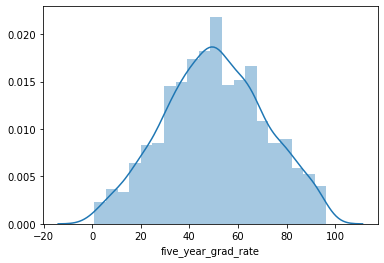

In [76]:
# Examine distribution of target
sns.distplot(five_college_df['five_year_grad_rate']);

In [91]:
# Reset index
five_college_df.reset_index(inplace=True)

In [92]:
# Drop columns not used in final model
final_df = five_college_df.loc[:,['out_state_tuition','percent_admitted', 'average_gpa','median_act_composite',
                                  'pell_percent', "retention_rate",  "percent_part_time", 'act_and_test_required',
                                  'five_year_grad_rate']]

In [93]:
# Prepare the data for modeling
x_train, x_test, y_train, y_test = train_test_split_data(final_df)

**Examine train data with cross validation to find model to tune**

In [99]:
linear_regression_model_testing(x_train, y_train)

Linear regression results:
R^2 Train: 0.7691739565308593,
R^2 Train: 0.7607711886394566,
MSE: 100.54591637232338,


In [101]:
linear_regression_model_testing_with_scaling(x_train, y_train)

Linear regression results with scaling:
R^2 Train: 0.7690308330060912,
R^2 Train: 0.7644001420101313,
MSE: 99.6351268671157,


In [102]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 100000, 1000000]
for alpha in alphas:
    print(alpha)
    ridge_regression_model_testing(x_train, y_train, alpha)

0.001
Ridge regression results:
R^2 Train: 0.7688189545529999,
R^2 Train: 0.7625226459823125,
MSE: 99.37914117215857,
0.01
Ridge regression results:
R^2 Train: 0.7690184519445128,
R^2 Train: 0.7635475426962846,
MSE: 99.72633915636746,
0.1
Ridge regression results:
R^2 Train: 0.7691267276991022,
R^2 Train: 0.7641728255194014,
MSE: 99.90729919124287,
1
Ridge regression results:
R^2 Train: 0.7688530310530707,
R^2 Train: 0.7639088152613096,
MSE: 99.25652565856713,
10
Ridge regression results:
R^2 Train: 0.769003486031751,
R^2 Train: 0.7583147270422511,
MSE: 100.75810317500836,
100
Ridge regression results:
R^2 Train: 0.7675886519584031,
R^2 Train: 0.7580338878417077,
MSE: 100.59889668570082,
1000
Ridge regression results:
R^2 Train: 0.7661088998336767,
R^2 Train: 0.7599185860106046,
MSE: 100.51925369525642,
100000
Ridge regression results:
R^2 Train: 0.7359732296062287,
R^2 Train: 0.7306631206431489,
MSE: 112.75762128243358,
1000000
Ridge regression results:
R^2 Train: 0.6067968770356643,


In [103]:
for alpha in alphas:
    print(alpha)
    ridge_regression_model_testing_with_scaling(x_train, y_train, alpha)

0.001
Ridge regression results with scaling:
R^2 Train: 0.7693022979181995,
R^2 Train: 0.762297224743425,
MSE: 100.63585566499711,
0.01
Ridge regression results with scaling:
R^2 Train: 0.7691125000321067,
R^2 Train: 0.7627468042004357,
MSE: 100.07689889700029,
0.1
Ridge regression results with scaling:
R^2 Train: 0.7690512659890205,
R^2 Train: 0.760939346682315,
MSE: 100.18142489225623,
1
Ridge regression results with scaling:
R^2 Train: 0.7691429215454288,
R^2 Train: 0.7634026964642432,
MSE: 100.05195409740246,
10
Ridge regression results with scaling:
R^2 Train: 0.7687856921266827,
R^2 Train: 0.7571860044434272,
MSE: 100.13843862369362,
100
Ridge regression results with scaling:
R^2 Train: 0.7676037524987118,
R^2 Train: 0.76080747067386,
MSE: 100.16101633500621,
1000
Ridge regression results with scaling:
R^2 Train: 0.7254395857005906,
R^2 Train: 0.7226159051041965,
MSE: 116.89725719312221,
100000
Ridge regression results with scaling:
R^2 Train: 0.058388195199172,
R^2 Train: 0.0544

In [104]:
for alpha in alphas:
    print(alpha)
    lasso_regression_model_testing(x_train, y_train, alpha)

0.001
LASSO regression results:
R^2 Train: 0.7692311763093115,
R^2 Train: 0.7605115446060261,
MSE: 100.71047710399435,
0.01
LASSO regression results:
R^2 Train: 0.769203649272727,
R^2 Train: 0.755348118964416,
MSE: 101.38175470844219,
0.1
LASSO regression results:
R^2 Train: 0.7687142484480001,
R^2 Train: 0.7602746311490869,
MSE: 101.10991337588948,
1
LASSO regression results:
R^2 Train: 0.7660122755915859,
R^2 Train: 0.7577413386143119,
MSE: 101.5307456646133,
10
LASSO regression results:
R^2 Train: 0.7531967395727426,
R^2 Train: 0.7485606600046841,
MSE: 105.137690956623,
100
LASSO regression results:
R^2 Train: 0.527369825891425,
R^2 Train: 0.5221338945475257,
MSE: 200.95134065222638,
1000
LASSO regression results:
R^2 Train: 0.5081988607584405,
R^2 Train: 0.5034346736091534,
MSE: 208.31357577613184,
100000
LASSO regression results:
R^2 Train: 0.32609904280735164,
R^2 Train: 0.32484791419394343,
MSE: 285.05174865357685,
1000000
LASSO regression results:
R^2 Train: 0.0,
R^2 Train: -0.

In [105]:
for alpha in alphas:
    print(alpha)
    lasso_regression_model_testing_with_scaling(x_train, y_train, alpha)

0.001
LASSO regression results with scaling:
R^2 Train: 0.7694403635455844,
R^2 Train: 0.7604900090858363,
MSE: 101.26462654623838,
0.01
LASSO regression results with scaling:
R^2 Train: 0.7691951026505308,
R^2 Train: 0.7619355081253592,
MSE: 100.4044992294112,
0.1
LASSO regression results with scaling:
R^2 Train: 0.7688167949543289,
R^2 Train: 0.7602212062610307,
MSE: 99.88984376416401,
1
LASSO regression results with scaling:
R^2 Train: 0.7636487771198006,
R^2 Train: 0.7586936998846878,
MSE: 101.92440176301666,
10
LASSO regression results with scaling:
R^2 Train: 0.42254516120619867,
R^2 Train: 0.41806204404533087,
MSE: 245.43397611723253,
100
LASSO regression results with scaling:
R^2 Train: 0.0,
R^2 Train: -0.0028592311434194606,
MSE: 422.6852453606745,
1000
LASSO regression results with scaling:
R^2 Train: 0.0,
R^2 Train: -0.009162312715643762,
MSE: 423.7494555763781,
100000
LASSO regression results with scaling:
R^2 Train: 0.0,
R^2 Train: -0.004242145698488642,
MSE: 422.913009729

**Move forward with final linear regression model with scaling**

In [106]:
# Assess final model (train and test data)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.values)  
x_test_scaled = scaler.transform(x_test.values)

linear_regression = LinearRegression()
linear_regression.fit(x_train_scaled, y_train)
y_pred = linear_regression.predict(x_test_scaled)

r2_train = linear_regression.score(x_train_scaled, y_train)
r2_test = linear_regression.score(x_test_scaled, y_test)
mse = mean_squared_error(y_test, y_pred)

In [107]:
# Final model metrics
r2_train

0.7685178029704571

In [108]:
# Final model metrics
r2_test

0.7436771145268481

In [109]:
# Final model metrics
mse

112.38312216081705

In [110]:
# Get coefficients for final model
list(zip(x_train.columns, linear_regression.coef_))

[('out_state_tuition', 5.806280222800988),
 ('percent_admitted', -0.5814494489727897),
 ('average_gpa', 1.5275872237989219),
 ('median_act_composite', 2.9495224940282885),
 ('pell_percent', -2.330366500737452),
 ('retention_rate', 7.3061347731299255),
 ('percent_part_time', -2.2542213755680063),
 ('act_and_test_required', 0.5063790959358515)]

In [111]:
# Get y-intercept
linear_regression.intercept_

50.68340684410645

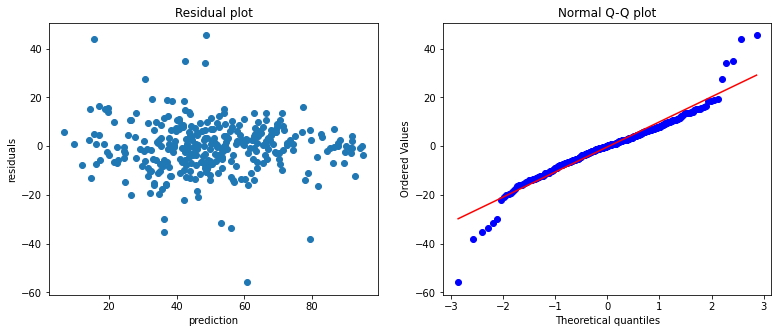

In [116]:
# Linear assumption #1
plt.figure(figsize=(20,5))
    
plt.subplot(1, 3, 2)
res = y_test - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")
    
plt.subplot(1, 3, 3)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

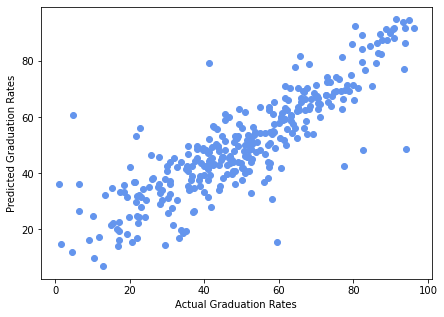

In [115]:
plt.figure(figsize=(7,5))

plt.scatter(y_test, y_pred, color="Cornflowerblue")

plt.xlabel("Actual Graduation Rates")
plt.ylabel("Predicted Graduation Rates");